In [8]:
import numpy as np
import matplotlib.pyplot as plt 
import numpy.random as rand
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy.spatial import KDTree

In this notebook I will outline and attempt to plot and describe the dynamics of the Damped pendulum with a constant forcing torque. 

There are here four main cases of note:
1. Overdamped Pendulum
2. Generic Case: Torque I < 1 (Bistable)
3. Dimensionless Torque I > 1 (No Libration)
4. Torque around the Critical Torque I_c < 1 and the Homoclinic Bifurcation

The application of this model to the analogous system, the Josephson Junction will also be considered briefly.

The equation of motion with constant torque is autonomous with degree N = 2, and is given by:
$\ddot{\theta}+\alpha\dot{\theta}+sin\theta = I$
... having normalised and set the period arbitrarily to $2\pi$ such as to rescale the natural frequency $\omega_{0}$ to 1.

As such it can be represented by the mapping F such that

$F:$ <br>

$\dot{X}_1 \mapsto X_2$ <br>


$\dot{X}_2 \mapsto I -\alpha X_2 - sinX_1$

We begin by confirming that this is dissipative:

$\nabla.\underline{F} = \partial{F_1}/\partial{X_1} + \partial{F_2}/\partial{X_2} = -\alpha < 0$

As such the system is conservative only in the case where $\alpha = 0$, from which we note the recovery of the undamped case.

In [9]:
# ----- RKF45 INTEGRATOR -----
def rkf45_step(grad, time, state, step_size, tol=1e-6):
    """
    A single step of the adaptive RKF45 method.
    """
    a = [0, 1/4, 3/8, 12/13, 1, 1/2]
    b = [
        [],
        [1/4],
        [3/32, 9/32],
        [1932/2197, -7200/2197, 7296/2197],
        [439/216, -8, 3680/513, -845/4104],
        [-8/27, 2, -3544/2565, 1859/4104, -11/40]
    ]
    c4 = [25/216, 0, 1408/2565, 2197/4104, -1/5, 0]
    c5 = [16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55]

    k = []
    for i in range(6):
        step_sum = np.sum([b[i][j] * k[j] for j in range(i)], axis=0) if i > 0 else 0
        k.append(step_size * grad(time + a[i] * step_size, state + step_sum))

    y4 = state + np.sum([c4[i] * k[i] for i in range(6)], axis=0)
    y5 = state + np.sum([c5[i] * k[i] for i in range(6)], axis=0)
    
    error = np.linalg.norm(y5 - y4)  
    safety_factor = 0.9  
    if error > tol:
        new_step_size = safety_factor * step_size * (tol / error) ** 0.25
    else:
        new_step_size = safety_factor * step_size * (tol / error) ** 0.2

    return time + step_size, y5, new_step_size


def rkf45_until_boundary(grad, time, state, step_size, domain, max_steps=50000, reverse=False):
    """
    Integrates forward (or backward if reverse=True) until the state reaches the boundary.
    """
    states, times = [state], [time]
    step_size = step_size if not reverse else -step_size  

    for _ in range(max_steps):
        time, state, step_size = rkf45_step(grad, times[-1], states[-1], step_size)

        if not (domain[0][0] <= state[0] <= domain[0][1] and domain[1][0] <= state[1] <= domain[1][1]):
            break

        times.append(time)
        states.append(state)

    return np.array(times), np.array(states)

Now we seek to use Linear stability analysis to determine the fixed points and their nature and the allowed set of parameters. In doing so we hope to spot the limiting cases for the dynamics of this system. I've chosen to first use MC methods in N-dimensional space to determine the fixed points. Analysis of the Jacobian at these fixed points will then classify them (In up to 2D initially bc i cba to make this fully general, but should be straightforwardly generalisable). 

Fixed points found:
[[ 5.08212489e-01  7.67680900e-03]
 [ 6.79121686e+00  5.91984960e-03]
 [-5.75456424e+00 -8.71940947e-03]
 [-3.67647220e+00 -7.82030760e-04]
 [ 2.62216173e+00  8.24434386e-03]
 [ 8.90403336e+00  7.71728524e-03]]


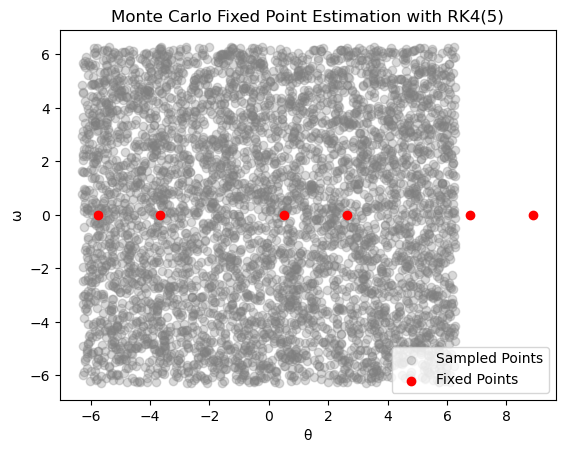

In [10]:
def bistable_grad(time, state, m=1.0, b=1.0, I = 0.5):
    """
    Produce a state array for the damped pendulum, forced by a constant torque.
    Note that time has been rescaled such as to more easily simplify the EoM
    Parameters
    ----------
    time : float
        The time at which the pendulum's conditions are being evaluated.
    state: list
        The current state of the pendulum. Single list in [theta, theta_dot] form.
    m : float, optional
        The mass of the pendulum. The default is 1.0
    b : float, optional
        Normalised damping factor of the pendulum [unitless]. The default is 1.0
    I: float
        Normalised constant torque applied to the system. The default is 0.5.
    Returns
    -------
    np.ndarray
        Time derivative of first generalised coordinate - the angular velocity,
        time derivative of second generalised coordinate - the angular acceleration.
    
    """

    theta, theta_dot = state[0], state[1]
    
    x1_dot = theta_dot
    x2_dot = I - np.sin(theta) - b * theta_dot
    
    return np.array([x1_dot, x2_dot])


def remove_close_points_kdtree(points, min_distance):
    """remove points that are closer than some minimum distance using a KDTree algo."""
    if points.size == 0:
        return points

    tree = KDTree(points)
    keep = np.ones(len(points), dtype=bool)  # Mask to track kept points

    for i, p in enumerate(points):
        if keep[i]:  # Only check if not already removed
            neighbors = tree.query_ball_point(p, min_distance)
            neighbors.remove(i)  # Remove self from neighbor list
            keep[neighbors] = False  # Mark close neighbors as redundant

    return points[keep]

    
# Parameters
N = 2   # Dimensionality of Problem
num_samples = 5000 # Number of MC samples : adapt as required
max_iterations = 100 # Allowed 'steps' of the flow in attempting to converge to a fixed point
tol = 1e-3 # Convergence condition tolerance
dt = 0.1  # Time step for RK45

# Define sampling domain
domain = [(-2*np.pi, 2*np.pi), (-2*np.pi, 2*np.pi)]  # Only for N = 2
min_dist = 0.2 # Defines how close we allow fixed points to be to each other for the fixed point finder

#First we generate the random points [e.g like in the MC2 TCP bookwork]
samples = np.array([
    np.random.uniform(low, high, num_samples) for low, high in domain
]).T


fixed_points = []
for x0 in samples:
    x = x0.copy()
    time = 0  # Initial Time 
    for _ in range(max_iterations):
        time, x_next, _ = rkf45_step(bistable_grad, time, x, dt)
        if np.linalg.norm(x_next - x) < tol:
            fixed_points.append(x_next)
            break
        x = x_next

# Need tpo remove duplicate values - use the KDTree method
fixed_points = np.array(fixed_points)
if fixed_points.size > 0:
    fixed_points = remove_close_points_kdtree(fixed_points, min_dist)


# Print results
print("Fixed points found:")
print(fixed_points)


if fixed_points.size > 0:
    plt.clf()
    plt.xlim(-2*np.pi,2*np.pi)
    plt.scatter(samples[:, 0], samples[:, 1], color='gray', alpha=0.3, label='Sampled Points')
    plt.scatter(fixed_points[:, 0], fixed_points[:, 1], color='red', label='Fixed Points')
    plt.xlabel('θ̇')
    plt.ylabel('ω')
    plt.legend()
    plt.title('Monte Carlo Fixed Point Estimation with RK4(5)')
    plt.show()


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


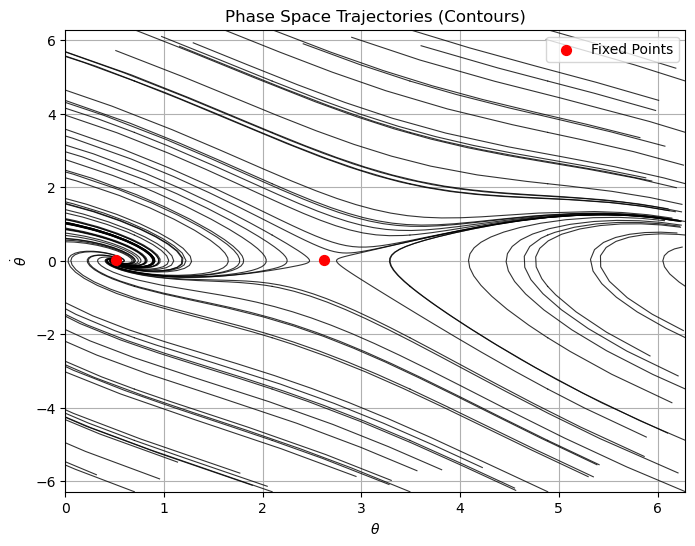

In [11]:
# ----- PHASE SPACE PLOTTING -----
def plot_orbit(x0_vect, domain, forward=True, backward=True):
    """
    Plots a trajectory starting from x0_vect in both forward and backward directions.
    """
    t_0 = 0
    step_size = dt  

    if forward:
        _, states_fwd = rkf45_until_boundary(bistable_grad, t_0, x0_vect, step_size, domain, reverse=False)
        plt.plot(states_fwd[:, 0], states_fwd[:, 1], lw=0.8, alpha=0.8, color="black")

    if backward:
        _, states_bwd = rkf45_until_boundary(bistable_grad, t_0, x0_vect, step_size, domain, reverse=True)
        plt.plot(states_bwd[:, 0], states_bwd[:, 1], lw=0.8, alpha=0.8, color="black")


# Generate a grid of initial conditions
n_theta = 10  
n_theta_dot = 10  
theta_vals = np.linspace(domain[0][0], domain[0][1], n_theta)
theta_dot_vals = np.linspace(domain[1][0], domain[1][1], n_theta_dot)

plt.figure(figsize=(8, 6))
plt.xlim(0,2*np.pi)
plt.ylim(domain[1])

# Plot trajectories covering the entire phase space
for theta0 in theta_vals:
    for theta_dot0 in theta_dot_vals:
        plot_orbit(np.array([theta0, theta_dot0]), domain)

# Plot fixed points
if fixed_points.size > 0:
    plt.scatter(fixed_points[:, 0], fixed_points[:, 1], color='red', s=50, label='Fixed Points', zorder=10)

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.title('Phase Space Trajectories (Contours)')
plt.legend()
plt.grid(True)
plt.show()

Now for this case I am interested in classifying the fixed points using Linear Stability Analysis, and by generalising these ideas, in determining the first Lyapunov Exponent and the Floquet Multipliers. To do this I'm going to try to applu the BPD method to the Jacobian of this system at the fixed points.

As the above phase portrait is $2\pi$ periodic, I'll choose to constrain the array containing the two fixed points to just the ones between 0 and $2\pi$, safe in the knowledge that this behaviour describes the whole behaviour of the system.

In [12]:
lower_limit = 0
upper_limit = 2*np.pi
index_1 = (fixed_points[:, 0] > lower_limit)
index_2 = (fixed_points[:, 0] < upper_limit)
valid_indices = index_1 & index_2
unique_fixed_points = fixed_points[valid_indices, :]
print('In the asymptotic phase space, the fixed points are at:',unique_fixed_points[0],' and ', unique_fixed_points[1])
print()
# Jacobian function
def jacobian(state, b=1.0, I=0.5):
    theta, theta_dot = state[0], state[1]
    J = np.array([[0, 1], [-np.cos(theta), -b]])
    return J

# Function to classify the fixed point based on trace and determinant
def classify_fixed_point(J):
    trace = np.trace(J)  # Tr(J)
    determinant = np.linalg.det(J)  # det(J)
    
    # Classification logic based on trace and determinant
    if trace > 0 and determinant > 0:
        return 'Source (unstable, attracting)'
    elif trace < 0 and determinant > 0:
        return 'Sink (stable, attracting)'
    elif trace == 0 and determinant > 0:
        return 'Center (stable)'
    elif trace > 0 and determinant < 0:
        return 'Saddle (unstable)'
    elif trace < 0 and determinant < 0:
        return 'Saddle (stable, repelling)'
    elif trace == 0 and determinant < 0:
        return 'Saddle (indeterminate stability)'
    elif trace == 0 and determinant == 0:
        return 'Degenerate Fixed Point'
    else:
        return 'Unclassified'

# Apply the Jacobian function and classify each fixed point
for fixed_point in unique_fixed_points:
    jacobian_at_fixed_point = jacobian(fixed_point)
    classification = classify_fixed_point(jacobian_at_fixed_point)
    
    # Format theta and theta_dot to 3 decimal places
    formatted_theta = f"{fixed_point[0]:.3f}"
    formatted_theta_dot = f"{fixed_point[1]:.3f}"
    
    print(f"Fixed point (theta, omega): ({formatted_theta}, {formatted_theta_dot})")
    print(f"Jacobian is:\n{jacobian_at_fixed_point}")
    print(f"Classification: {classification}")
    print()  # Blank line for readability

In the asymptotic phase space, the fixed points are at: [0.50821249 0.00767681]  and  [2.62216173 0.00824434]

Fixed point (theta, omega): (0.508, 0.008)
Jacobian is:
[[ 0.          1.        ]
 [-0.87361573 -1.        ]]
Classification: Sink (stable, attracting)

Fixed point (theta, omega): (2.622, 0.008)
Jacobian is:
[[ 0.         1.       ]
 [ 0.8681018 -1.       ]]
Classification: Saddle (stable, repelling)



Having plotted the phase space and classified the fixed points we now seek to quantify the Lyapunov Exponents. 

Instead of using the Gram-Schmidt Orthonormalisation method which is standard, we seek to utilise the method laid out by Balcerzak, Pikunov and Dabrowski ('The fastest, simplified method of Lyapunov exponents
spectrum estimation for continuous-time dynamical systems') wherein only n - 1 perturbations are required to be integrated to obtain a complete spectrum (though the specifics are complicated).

Factors taken into consideration:
Growth rate will be averaged to minimise the effect of spikes
The perturbations are going to be normalised at the beginning to avoid over/underflow during integration

In [13]:
def lyapunov_exponent_integration(x0, t_0, t_end, n_perturbations, dt=0.01, tol=1e-6):
    """
    Compute Lyapunov exponents using the BPD method with rkf45.
    
    x0: Initial state [theta, theta_dot]
    t_0: Initial time
    t_end: Final time for integration
    n_perturbations: Number of perturbations (n - 1 for n-dimensional systems)
    """
    # Initialize perturbation vectors
    perturbations = np.random.rand(n_perturbations, len(x0))  # n-1 perturbations for n-dimensional system
    perturbations /= np.linalg.norm(perturbations, axis=1)[:, None]  # Normalize perturbations

    # Concatenate state and perturbations for the integration
    initial_conditions = np.concatenate([x0, perturbations.flatten()])
    
    # Function to evolve the system with perturbations
    def system_with_perturbations(t, y):
        state = y[:2]  # Extract state (theta, theta_dot)
        perturb = y[2:].reshape((n_perturbations, 2))  # Reshape perturbations

        dydt = bistable_grad(t, state)  # System dynamics using bistable_grad

        # Compute the evolution of the perturbations
        perturb_evolution = np.zeros_like(perturb)
        for i in range(n_perturbations):
            perturb_evolution[i] = bistable_grad(t, state) + perturb[i]

        return np.concatenate([dydt, perturb_evolution.flatten()])

    # Define the domain for theta and theta_dot (example range)
    domain = [(-2 * np.pi, 2 * np.pi), (-2 * np.pi, 2 * np.pi)]  # Set the domain for theta and theta_dot

    # Integrate using rkf45_until_boundary
    # Ensure that the domain is passed correctly and integrate until the system reaches t_end
    _, trajectory_with_perturbations = rkf45_until_boundary(system_with_perturbations, t_0, initial_conditions, dt, domain, t_end)

    # Extract the perturbations' magnitudes at the final time
    perturbation_magnitudes = np.linalg.norm(trajectory_with_perturbations[:, 2:], axis=1)
    
    # Compute the growth rates of perturbations (log of ratio of magnitude to initial magnitude)
    growth_rates = np.log(perturbation_magnitudes / perturbation_magnitudes[0])

    # Compute the Lyapunov exponents by averaging the growth rates
    # Averaging over the time steps
    average_growth_rate = np.mean(growth_rates)  # Average growth rate
    lyapunov_exponent = average_growth_rate / (t_end - t_0)
    
    return lyapunov_exponent

# Example usage:
x0 = [np.pi / 2, 0]  # Initial state [theta, theta_dot]
t_0 = 0  # Initial time
t_end = 100  # End time for integration
n_perturbations = 2  # For a 2D system, n-1 = 1 perturbation

lyapunov_exponent = lyapunov_exponent_integration(x0, t_0, t_end, n_perturbations)

if lyapunov_exponent < 0 or lyapunov_exponent == 0:
    print('Lyapunov exponent:' , lyapunov_exponent, ' - This system is Lyapunov Stable barring significant Perron effects.')
else: print('Lyapunov exponent:' , lyapunov_exponent, ' - This system is Lyapunov Unstable.')
#print("Lyapunov exponent:", lyapunov_exponent)

Lyapunov exponent: 0.04977854422806471  - This system is Lyapunov Unstable.


Note: The Oseledets multiplicative ergodic theorem guarantees that LEs are independent of the initial condition - this represents a characteristic value for this system.

I now seek to determine the Floquet multipliers if applicable by the Linearisation and evaluation of the Monodromy matrix. To first determine whether the phase space contains a stable limit cycle I'm possibly going to try and implement the Poincare-Bendixson condition.

In the case of $I < I_c < 1$ there is no stable limit cycle as the only possible dynamics are constrained to librations. To demonstrate this I will project the phase space determined earlier onto a physically intuitive topology, the phase cylinder, with I as the radial component.